크롤링한 종목별(기업별) 재무제표 지표를 4개의 파생지수로 변환

In [2]:
import os
os.chdir('C:/Users/myhyu/OneDrive/Desktop/2024 미래에셋/InvestmentPropensity')

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_path = 'C:/Windows/Fonts/malgun.ttf'  # Windows의 경우
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy import stats
import statsmodels.api as sm

# 0. 데이터셋

- finance_table_cleaned.csv
- code.csv
- ev_ebitda_table.csv
- 베타_크롤링.csv
- 일일수익률표준편차.csv
---

1. 수익성 지수 : 영업이익률, 순이익률
2. 효율성 지수 : PBR, EV/EBITDA
3. 퀄리티 지수 : ROE, 부채비율
4. 변동성 지수 : 베타, 일일수익률표준편차

## 0.1 finance_table_ver1.csv
2696행

In [5]:
df = pd.read_csv('finance_table_ver1.csv',  encoding='utf-8', skiprows=1)
new_colnames = ['기업코드','영업이익률','순이익률','매출액차','부채비율','PER','PBR','ROE','매출성장률']
df.columns = new_colnames
df

,기업코드,영업이익률,순이익률,매출액차,부채비율,PER,PBR,ROE,매출성장률
0,095570,7.95,2.16,2448.0,305.26,13.03,0.52,4.26,-0.970874
1,006840,8.08,3.56,11934.0,319.33,10.23,0.33,3.33,3.235294
2,027410,9.55,9.71,1185.0,14.85,4.76,0.22,4.64,-3.970827
3,282330,1.67,1.20,19538.0,214.53,10.62,1.98,19.69,-4.234879
4,138930,11.75,9.61,26505.0,1275.09,3.97,0.24,6.30,9.213400
...,...,...,...,...,...,...,...,...,...
2620,024060,-0.59,0.41,306.0,17.30,179.80,1.84,1.06,-4.968944
2621,010240,9.20,9.77,353.0,25.14,5.56,0.62,12.89,2.023121
2622,189980,8.20,3.72,225.0,112.21,12.28,0.91,7.91,15.979381
2623,037440,3.17,5.63,563.0,169.13,13.10,1.19,10.41,-14.437690


In [6]:
df.isna().sum()

기업코드       0
영업이익률     90
순이익률      91
매출액차      97
부채비율       0
PER      156
PBR       14
ROE      195
매출성장률    136
dtype: int64

## 0.2 code.csv
2362행

In [7]:
df_name = pd.read_csv('code.csv', encoding='utf-8')
df_name = df_name.rename(columns={'종목명':'기업명', '종목코드':'기업코드'})
df_name

,Unnamed: 0,기업코드,기업명,시장구분,업종명,종가,대비,등락률,시가총액
0,0,095570,AJ네트웍스,KOSPI,서비스업,4550,0,0.00,205900053450
1,1,006840,AK홀딩스,KOSPI,기타금융,14160,110,0.78,187585463760
2,2,027410,BGF,KOSPI,기타금융,3570,20,0.56,341708943870
3,3,282330,BGF리테일,KOSPI,유통업,105500,1600,1.54,1823452083000
4,4,138930,BNK금융지주,KOSPI,기타금융,8550,-80,-0.93,2753856144900
...,...,...,...,...,...,...,...,...,...
2691,1737,024060,흥구석유,KOSDAQ,유통,13830,-10,-0.07,207450000000
2692,1738,010240,흥국,KOSDAQ,기계·장비,5450,70,1.30,67158693200
2693,1739,189980,흥국에프엔비,KOSDAQ,음식료·담배,2250,55,2.51,90310110750
2694,1740,037440,희림,KOSDAQ,기타서비스,6120,270,4.62,85205547000


In [8]:
df_name.isna().sum()

Unnamed: 0    0
기업코드          0
기업명           0
시장구분          0
업종명           0
종가            0
대비            0
등락률           0
시가총액          0
dtype: int64

## 0.3 ev_ebitda_table.csv
2696행

In [9]:
df_ev = pd.read_csv('ev_ebitda_table.csv', encoding='cp949')
df_ev

,기업코드,EV,EBITDA,EV/EBITDA
0,095570,11528.0,615.0,18.744715
1,006840,27192.0,1606.0,16.931507
2,027410,6049.0,185.0,32.697297
3,282330,20343.0,1597.0,12.738259
4,138930,NaN,NaN,NaN
...,...,...,...,...
2691,024060,1572.0,-2.0,-786.000000
2692,010240,690.0,40.0,17.250000
2693,189980,1725.0,37.0,46.621622
2694,037440,947.0,32.0,29.593750


In [10]:
df_ev.isna().sum()

기업코드           0
EV           296
EBITDA       295
EV/EBITDA    317
dtype: int64

## 0.4 베타_크롤링.csv
2696행

In [11]:
df_beta = pd.read_csv('베타_크롤링.csv',encoding='utf-8',usecols=['종목 코드','베타 값'])
df_beta.rename(columns={'종목 코드':'기업코드','베타 값':'베타'}, inplace=True)
df_beta

,기업코드,베타
0,095570,0.52692
1,006840,0.46803
2,027410,0.65719
3,282330,0.29867
4,138930,0.40175
...,...,...
2691,024060,-0.24123
2692,010240,0.35645
2693,189980,0.42538
2694,037440,0.45468


In [12]:
df_beta.isna().sum()

기업코드      0
베타      128
dtype: int64

## 0.5 수익률.csv
2696행

In [13]:
df_std=pd.read_csv('수익률.csv',encoding='utf-8',usecols=['종목 코드','일별 수익률 표준편차'])
df_std=df_std.rename(columns={'종목 코드':'기업코드', '일별 수익률 표준편차':'일별수익률표준편차'})
df_std

,기업코드,일별수익률표준편차
0,095570,0.017551
1,006840,0.014387
2,027410,0.021352
3,282330,0.018335
4,138930,0.013072
...,...,...
2691,024060,0.058064
2692,010240,0.009593
2693,189980,0.017679
2694,037440,0.016560


In [14]:
df_std.isna().sum()

기업코드          0
일별수익률표준편차    48
dtype: int64

# 0.데이터 합치기

In [15]:
df = pd.merge(df, df_name[['기업코드','기업명']], on='기업코드', how='left')
df = pd.merge(df, df_ev, on='기업코드', how='left')
df = pd.merge(df, df_beta, on='기업코드', how='right')
df = pd.merge(df,df_std,on='기업코드', how='right')
df

,기업코드,영업이익률,순이익률,매출액차,부채비율,PER,PBR,ROE,매출성장률,기업명,EV,EBITDA,EV/EBITDA,베타,일별수익률표준편차
0,095570,7.95,2.16,2448.0,305.26,13.03,0.52,4.26,-0.970874,AJ네트웍스,11528.0,615.0,18.744715,0.52692,0.017551
1,006840,8.08,3.56,11934.0,319.33,10.23,0.33,3.33,3.235294,AK홀딩스,27192.0,1606.0,16.931507,0.46803,0.014387
2,027410,9.55,9.71,1185.0,14.85,4.76,0.22,4.64,-3.970827,BGF,6049.0,185.0,32.697297,0.65719,0.021352
3,282330,1.67,1.20,19538.0,214.53,10.62,1.98,19.69,-4.234879,BGF리테일,20343.0,1597.0,12.738259,0.29867,0.018335
4,138930,11.75,9.61,26505.0,1275.09,3.97,0.24,6.30,9.213400,BNK금융지주,NaN,NaN,NaN,0.40175,0.013072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2691,024060,-0.59,0.41,306.0,17.30,179.80,1.84,1.06,-4.968944,흥구석유,1572.0,-2.0,-786.000000,-0.24123,0.058064
2692,010240,9.20,9.77,353.0,25.14,5.56,0.62,12.89,2.023121,흥국,690.0,40.0,17.250000,0.35645,0.009593
2693,189980,8.20,3.72,225.0,112.21,12.28,0.91,7.91,15.979381,흥국에프엔비,1725.0,37.0,46.621622,0.42538,0.017679
2694,037440,3.17,5.63,563.0,169.13,13.10,1.19,10.41,-14.437690,희림,947.0,32.0,29.593750,0.45468,0.016560


In [16]:
df.dropna(inplace=True)
df.info()
#데이터분석에 사용하는 것이 아니기 때문에 결측치 모두 삭제 가능.
#2696 -> 2161

<class 'pandas.core.frame.DataFrame'>
Index: 2161 entries, 0 to 2695
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   기업코드       2161 non-null   object 
 1   영업이익률      2161 non-null   float64
 2   순이익률       2161 non-null   float64
 3   매출액차       2161 non-null   float64
 4   부채비율       2161 non-null   float64
 5   PER        2161 non-null   float64
 6   PBR        2161 non-null   float64
 7   ROE        2161 non-null   float64
 8   매출성장률      2161 non-null   float64
 9   기업명        2161 non-null   object 
 10  EV         2161 non-null   float64
 11  EBITDA     2161 non-null   float64
 12  EV/EBITDA  2161 non-null   float64
 13  베타         2161 non-null   float64
 14  일별수익률표준편차  2161 non-null   float64
dtypes: float64(13), object(2)
memory usage: 270.1+ KB


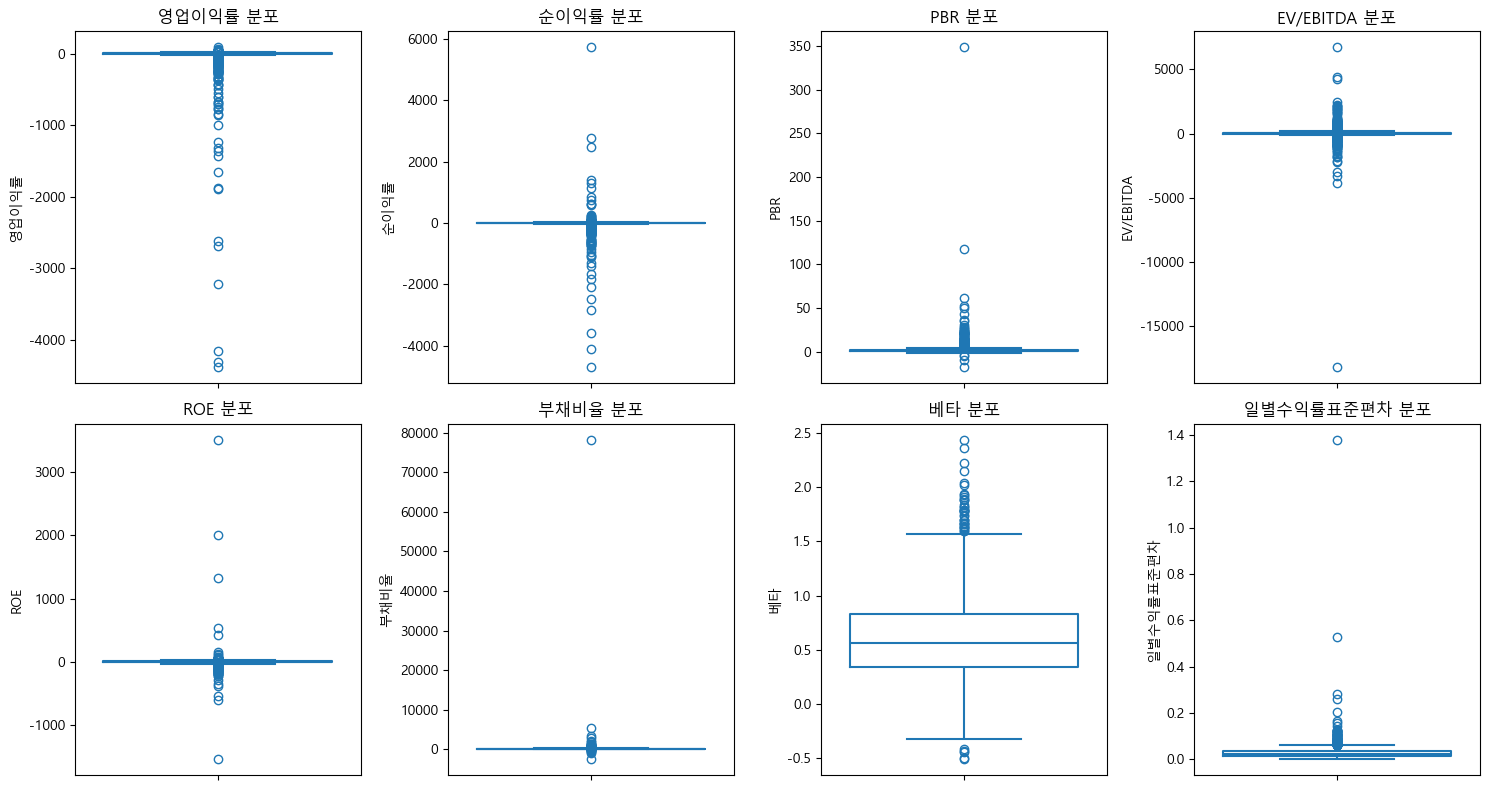

In [17]:
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
used_columns = ['영업이익률','순이익률','PBR','EV/EBITDA','ROE','부채비율','베타','일별수익률표준편차']

axes = axes.flatten()
for i, col in enumerate(used_columns):
    sns.boxplot(y=df[col], ax=axes[i], fill=False)
    axes[i].set_title(f'{col} 분포')

plt.tight_layout()
plt.show()
# 모든 지표에서 극단치가 굉장히 많음.
# 극단치 일시 제거 후 클러스터링.

---
# 1. 수익성 지수
- 영업이익률
- 순이익률

In [18]:
df1 = df[['영업이익률','순이익률']]
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2161 entries, 0 to 2695
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   영업이익률   2161 non-null   float64
 1   순이익률    2161 non-null   float64
dtypes: float64(2)
memory usage: 50.6 KB


### 1.1 수익성 데이터 극단치 제거

In [19]:
# 데이터 필터링 - 극단치 제거 (IQR 기준)
def remove_outliers_iqr(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[~((df < lower_bound) | (df > upper_bound)).any(axis=1)]

In [20]:
# 극단치 제거된 데이터
df1_cleaned = remove_outliers_iqr(df1)

df1_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1752 entries, 0 to 2695
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   영업이익률   1752 non-null   float64
 1   순이익률    1752 non-null   float64
dtypes: float64(2)
memory usage: 41.1 KB


C:\Users\myhyu\AppData\Local\Temp\ipykernel_29460\3640847394.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1_cleaned['영업이익률'], kde=True, ax=axes[0])
C:\Users\myhyu\AppData\Local\Temp\ipykernel_29460\3640847394.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1_cleaned['순이익률'], kde=T

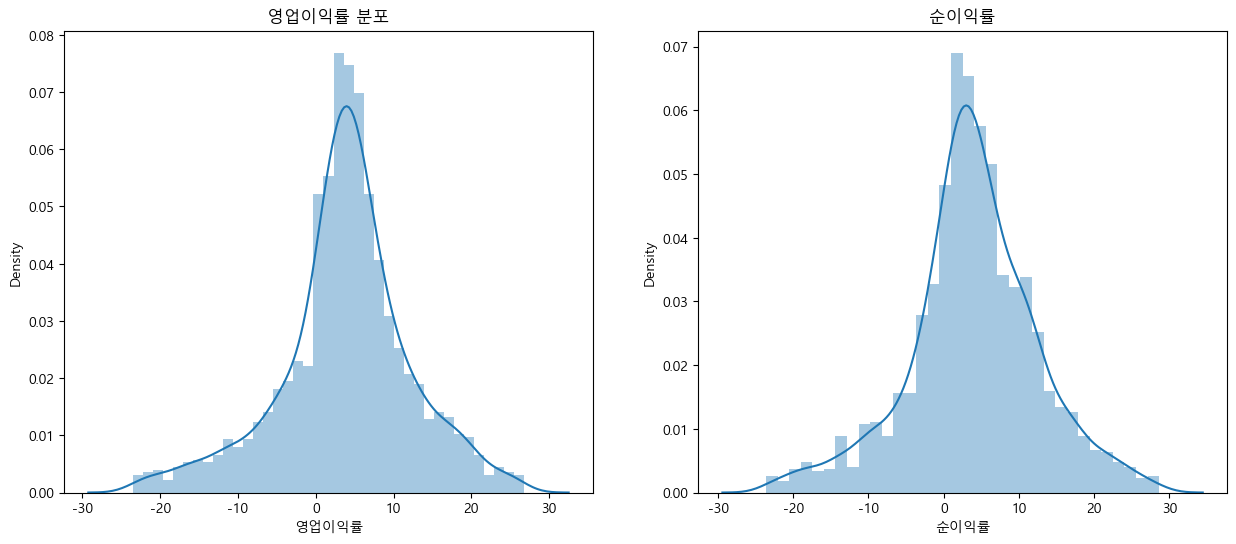

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# distplot
sns.distplot(df1_cleaned['영업이익률'], kde=True, ax=axes[0])
axes[0].set_title('영업이익률 분포')

# boxplot
sns.distplot(df1_cleaned['순이익률'], kde=True, ax=axes[1])
axes[1].set_title('순이익률')

plt.show()

### 1.2 수익성 데이터(극단치 제거) 클러스터링

In [22]:
# 데이터 표준화
scaler = StandardScaler()
scaled_data_cleaned1 = scaler.fit_transform(df1_cleaned)

# K-Means 클러스터링 수행
kmeans_cleaned1 = KMeans(n_clusters=2, random_state=42)
df1_cleaned['Cluster'] = kmeans_cleaned1.fit_predict(scaled_data_cleaned1)

# 클러스터링 결과
df1_cleaned['Cluster'].value_counts()

C:\Users\myhyu\AppData\Local\Temp\ipykernel_29460\2284671840.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_cleaned['Cluster'] = kmeans_cleaned1.fit_predict(scaled_data_cleaned1)


Cluster
0    959
1    793
Name: count, dtype: int64

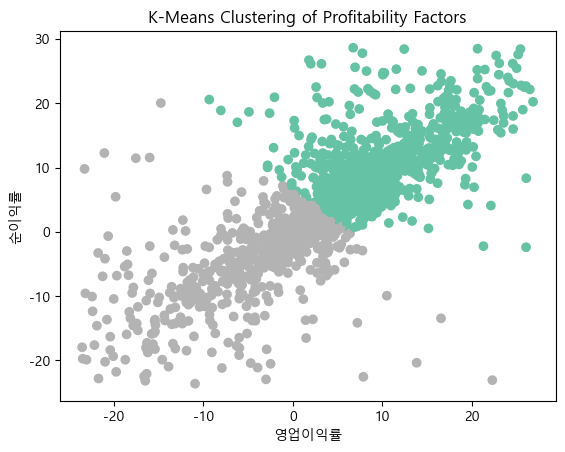

In [23]:
plt.scatter(df1_cleaned['영업이익률'], df1_cleaned['순이익률'], c=df1_cleaned['Cluster'], cmap='Set2' )
plt.xlabel('영업이익률')
plt.ylabel('순이익률')
plt.title('K-Means Clustering of Profitability Factors')
plt.show()

### 1.3 클러스터링 경계로 수익성 데이터 데이터 분류

In [24]:
# 원본 데이터 표준화
scaled_data_original1 = scaler.transform(df1)

# 클러스터링을 원본 데이터에 적용
def assign_cluster(row, kmeans_model, scaler):
    scaled_row = scaler.transform([row])
    return kmeans_model.predict(scaled_row)[0]

# 원본 데이터에 군집 분류 적용
df1['Cluster'] = df1.apply(lambda row: assign_cluster(row, kmeans_cleaned1, scaler), axis=1)

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

In [25]:
df1.Cluster.value_counts()

Cluster
1    1103
0    1058
Name: count, dtype: int64

In [26]:
df1['수익성'] = np.where(df1['Cluster'] == 0, 'p', 'P')

print(df1)

      영업이익률   순이익률  Cluster 수익성
0      7.95   2.16        0   p
1      8.08   3.56        0   p
2      9.55   9.71        0   p
3      1.67   1.20        1   P
5     13.31  10.27        0   p
...     ...    ...      ...  ..
2691  -0.59   0.41        1   P
2692   9.20   9.77        0   p
2693   8.20   3.72        0   p
2694   3.17   5.63        0   p
2695  11.93  12.50        0   p

[2161 rows x 4 columns]


C:\Users\myhyu\AppData\Local\Temp\ipykernel_29460\39036198.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['수익성'] = np.where(df1['Cluster'] == 0, 'p', 'P')


In [27]:
df1[['Cluster','수익성']].value_counts()

Cluster  수익성
1        P      1103
0        p      1058
Name: count, dtype: int64

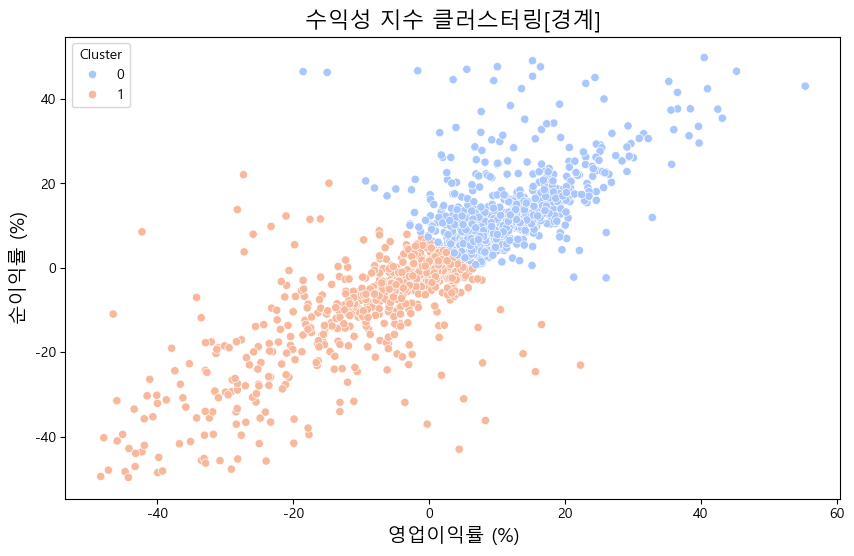

In [28]:
# 시각화
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(
    x='영업이익률', 
    y='순이익률', 
    hue='Cluster', 
    palette='coolwarm', 
    data=df1.query('영업이익률>-50& -50<순이익률<50')
)

# 그래프 제목과 축 레이블 설정
scatter_plot.set_title('수익성 지수 클러스터링[경계]', fontsize=16)
scatter_plot.set_xlabel('영업이익률 (%)', fontsize=14)
scatter_plot.set_ylabel('순이익률 (%)', fontsize=14)

plt.show()

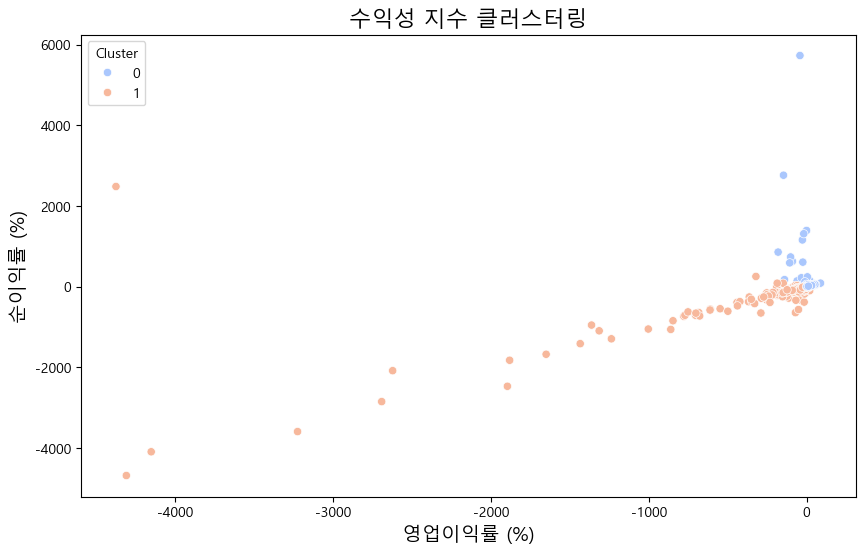

In [29]:
# 시각화
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(
    x='영업이익률', 
    y='순이익률', 
    hue='Cluster', 
    palette='coolwarm', 
    data=df1
)

# 그래프 제목과 축 레이블 설정
scatter_plot.set_title('수익성 지수 클러스터링', fontsize=16)
scatter_plot.set_xlabel('영업이익률 (%)', fontsize=14)
scatter_plot.set_ylabel('순이익률 (%)', fontsize=14)

plt.show()

In [30]:
df1.drop(columns=['Cluster'], inplace=True)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2161 entries, 0 to 2695
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   영업이익률   2161 non-null   float64
 1   순이익률    2161 non-null   float64
 2   수익성     2161 non-null   object 
dtypes: float64(2), object(1)
memory usage: 67.5+ KB


C:\Users\myhyu\AppData\Local\Temp\ipykernel_29460\1170605018.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.drop(columns=['Cluster'], inplace=True)


---
# 2. 효율성 (가치)
- PBR, EV/EBITDA

In [31]:
df2 = df[['PBR','EV/EBITDA']]
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2161 entries, 0 to 2695
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PBR        2161 non-null   float64
 1   EV/EBITDA  2161 non-null   float64
dtypes: float64(2)
memory usage: 50.6 KB


In [32]:
df2.corr()

,PBR,EV/EBITDA
PBR,1.000000,-0.036074
EV/EBITDA,-0.036074,1.000000


### 2.1 효율성 데이터 극단치 제거 
df2_cleaned

In [33]:
# 극단치 제거된 데이터
df2_cleaned = remove_outliers_iqr(df2)

df2_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1679 entries, 0 to 2695
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PBR        1679 non-null   float64
 1   EV/EBITDA  1679 non-null   float64
dtypes: float64(2)
memory usage: 39.4 KB


C:\Users\myhyu\AppData\Local\Temp\ipykernel_29460\3211236146.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df2_cleaned['PBR'], kde=True, ax=axes[0])
C:\Users\myhyu\AppData\Local\Temp\ipykernel_29460\3211236146.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df2_cleaned['EV/EBITDA'], kd

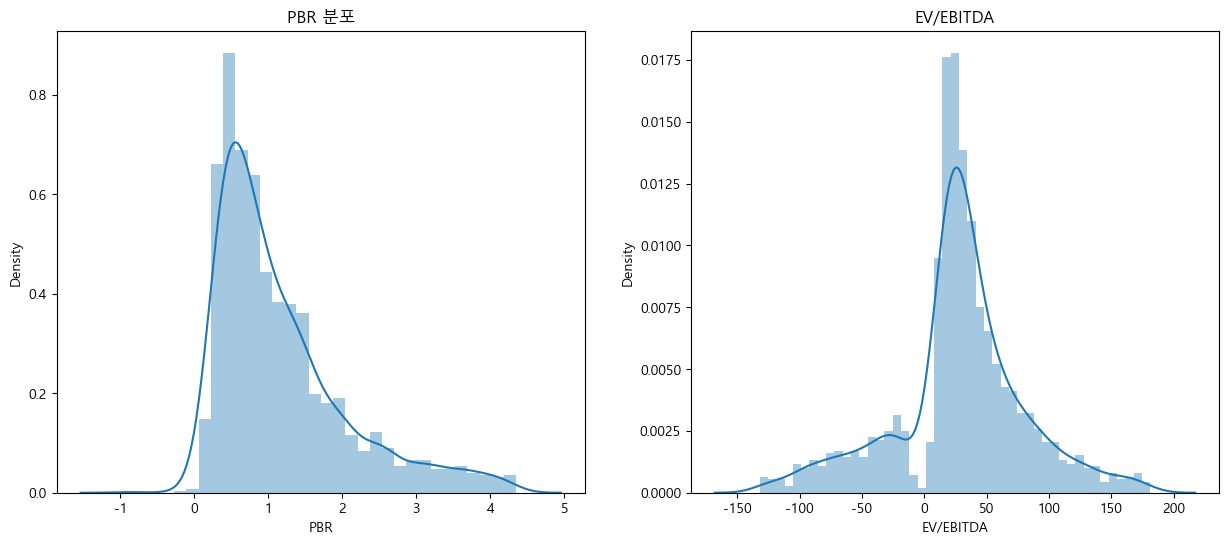

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# distplot
sns.distplot(df2_cleaned['PBR'], kde=True, ax=axes[0])
axes[0].set_title('PBR 분포')

# boxplot
sns.distplot(df2_cleaned['EV/EBITDA'], kde=True, ax=axes[1])
axes[1].set_title('EV/EBITDA')

plt.show()

### 2.2 효율성 데이터(극단치 제거) 클러스터링

In [35]:
# 데이터 표준화
scaler = StandardScaler()
scaled_data_cleaned2 = scaler.fit_transform(df2_cleaned)

# K-Means 클러스터링 수행
kmeans_cleaned2 = KMeans(n_clusters=2, random_state=42)
df2_cleaned['Cluster'] = kmeans_cleaned2.fit_predict(scaled_data_cleaned2)

# 클러스터링 결과
df2_cleaned['Cluster'].value_counts()

C:\Users\myhyu\AppData\Local\Temp\ipykernel_29460\746348728.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_cleaned['Cluster'] = kmeans_cleaned2.fit_predict(scaled_data_cleaned2)


Cluster
0    1330
1     349
Name: count, dtype: int64

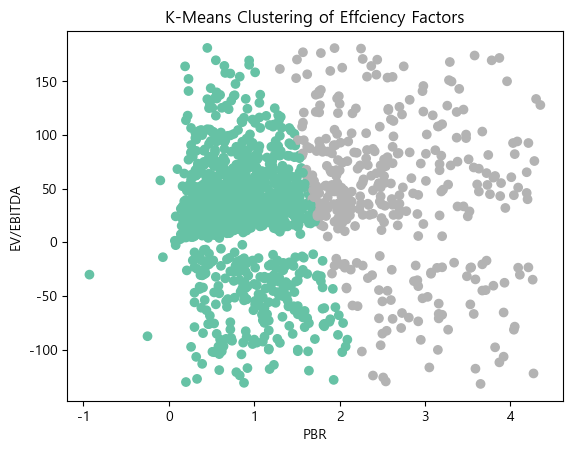

In [36]:
plt.scatter(df2_cleaned['PBR'], df2_cleaned['EV/EBITDA'], c=df2_cleaned['Cluster'], cmap='Set2' )
plt.xlabel('PBR')
plt.ylabel('EV/EBITDA')
plt.title('K-Means Clustering of Effciency Factors')
plt.show()

### 2.3 클러스터링 경계로 효율성 데이터 분류

In [37]:
# 원본 데이터 표준화
scaled_data_original = scaler.transform(df2)

# 원본 데이터에 군집 분류 적용
df2['Cluster'] = df2.apply(lambda row: assign_cluster(row, kmeans_cleaned2, scaler), axis=1)

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

In [38]:
df2.Cluster.value_counts()

Cluster
0    1472
1     689
Name: count, dtype: int64

In [39]:
df2['효율성'] = np.where(df2['Cluster'] == 0, 'e', 'E')
print(df2)

       PBR   EV/EBITDA  Cluster 효율성
0     0.52   18.744715        0   e
1     0.33   16.931507        0   e
2     0.22   32.697297        0   e
3     1.98   12.738259        1   E
5     0.77   41.559524        0   e
...    ...         ...      ...  ..
2691  1.84 -786.000000        0   e
2692  0.62   17.250000        0   e
2693  0.91   46.621622        0   e
2694  1.19   29.593750        0   e
2695  0.97   22.903226        0   e

[2161 rows x 4 columns]


C:\Users\myhyu\AppData\Local\Temp\ipykernel_29460\2153622056.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['효율성'] = np.where(df2['Cluster'] == 0, 'e', 'E')


In [40]:
df2[['Cluster','효율성']].value_counts()

Cluster  효율성
0        e      1472
1        E       689
Name: count, dtype: int64

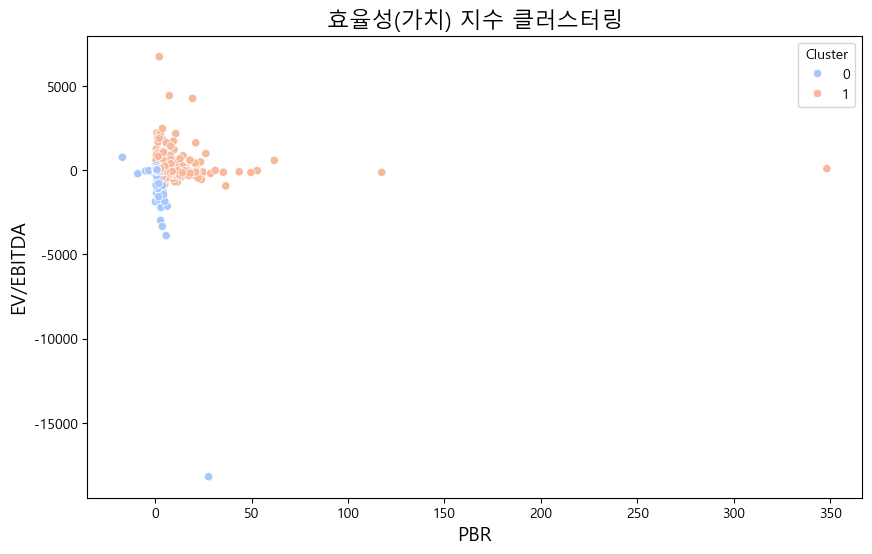

In [41]:
# 시각화
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(
    x='PBR', 
    y='EV/EBITDA', 
    hue='Cluster', 
    palette='coolwarm', 
    data=df2
)

# 그래프 제목과 축 레이블 설정
scatter_plot.set_title('효율성(가치) 지수 클러스터링', fontsize=16)
scatter_plot.set_xlabel('PBR', fontsize=14)
scatter_plot.set_ylabel('EV/EBITDA', fontsize=14)

plt.show()

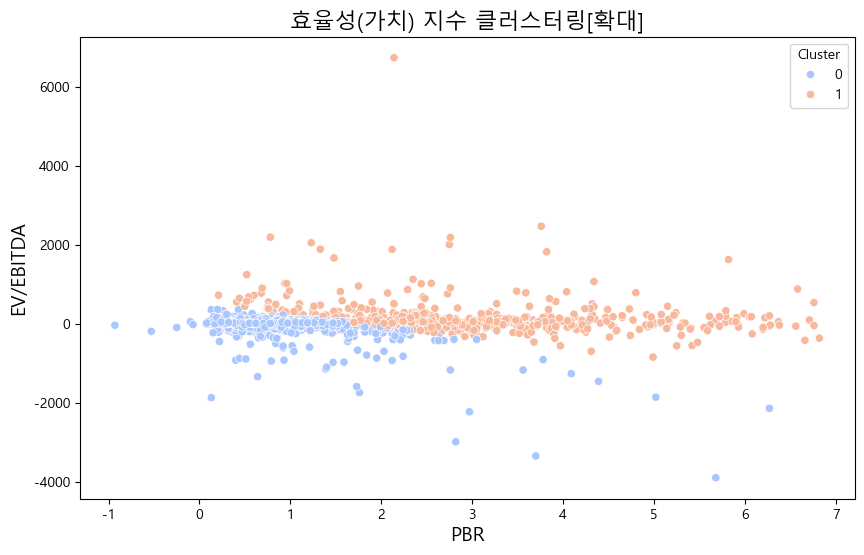

In [42]:
# 시각화
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(
    x='PBR', 
    y='EV/EBITDA', 
    hue='Cluster', 
    palette='coolwarm', 
    data=df2.query('-3<PBR<7')
)

# 그래프 제목과 축 레이블 설정
scatter_plot.set_title('효율성(가치) 지수 클러스터링[확대]', fontsize=16)
scatter_plot.set_xlabel('PBR', fontsize=14)
scatter_plot.set_ylabel('EV/EBITDA', fontsize=14)

plt.show()

In [43]:
df2.drop(columns=['Cluster'], inplace=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2161 entries, 0 to 2695
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PBR        2161 non-null   float64
 1   EV/EBITDA  2161 non-null   float64
 2   효율성        2161 non-null   object 
dtypes: float64(2), object(1)
memory usage: 67.5+ KB


C:\Users\myhyu\AppData\Local\Temp\ipykernel_29460\1758402841.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.drop(columns=['Cluster'], inplace=True)


---
## 3. 퀄리티

In [44]:
df3 = df[['ROE','부채비율']]
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2161 entries, 0 to 2695
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ROE     2161 non-null   float64
 1   부채비율    2161 non-null   float64
dtypes: float64(2)
memory usage: 50.6 KB


In [45]:
df3.corr()

,ROE,부채비율
ROE,1.000000,-0.100221
부채비율,-0.100221,1.000000


### 3.1 퀄리티 데이터 극단치 제거 
df3_cleaned

In [46]:
# 극단치 제거된 데이터
df3_cleaned = remove_outliers_iqr(df3)

df3_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1842 entries, 2 to 2695
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ROE     1842 non-null   float64
 1   부채비율    1842 non-null   float64
dtypes: float64(2)
memory usage: 43.2 KB


C:\Users\myhyu\AppData\Local\Temp\ipykernel_29460\2364691332.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df3_cleaned['ROE'], kde=True, ax=axes[0])
C:\Users\myhyu\AppData\Local\Temp\ipykernel_29460\2364691332.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df3_cleaned['부채비율'], kde=Tru

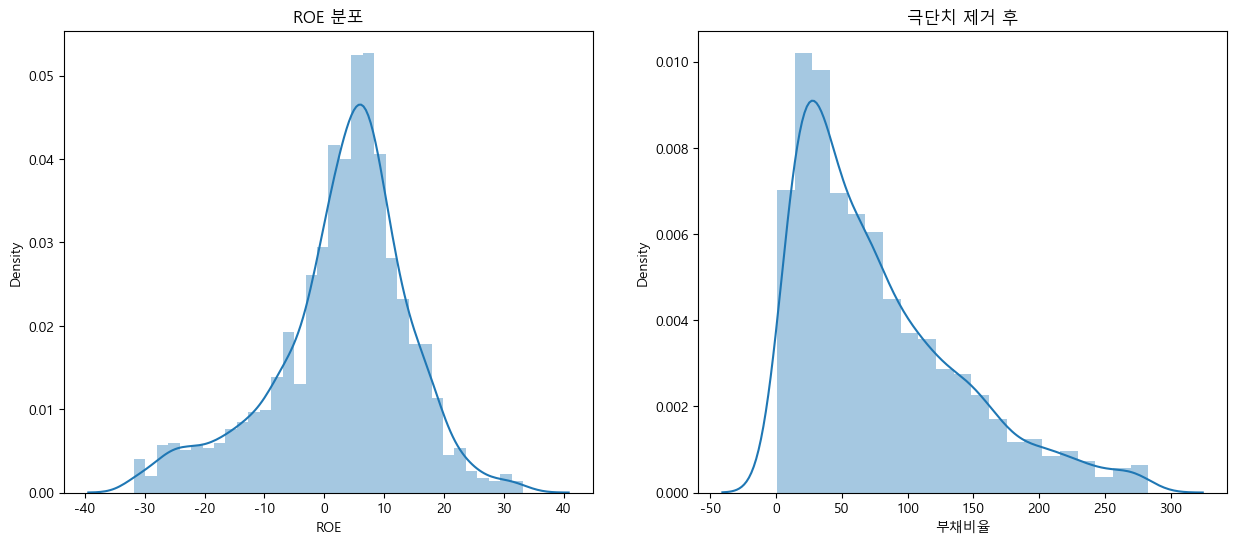

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# distplot
sns.distplot(df3_cleaned['ROE'], kde=True, ax=axes[0])
axes[0].set_title('ROE 분포')

# boxplot
sns.distplot(df3_cleaned['부채비율'], kde=True, ax=axes[1])
axes[1].set_title('부채비율 분포')

plt.title('극단치 제거 후')
plt.show()

### 3.2 퀄리티 지수 클러스터링

In [48]:
# 데이터 표준화
scaler = StandardScaler()
scaled_data_cleaned3 = scaler.fit_transform(df3_cleaned)

# K-Means 클러스터링 수행
kmeans_cleaned3 = KMeans(n_clusters=2, random_state=42)
df3_cleaned['Cluster'] = kmeans_cleaned3.fit_predict(scaled_data_cleaned3)

# 클러스터링 결과
df3_cleaned['Cluster'].value_counts()

C:\Users\myhyu\AppData\Local\Temp\ipykernel_29460\4254901446.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3_cleaned['Cluster'] = kmeans_cleaned3.fit_predict(scaled_data_cleaned3)


Cluster
1    1239
0     603
Name: count, dtype: int64

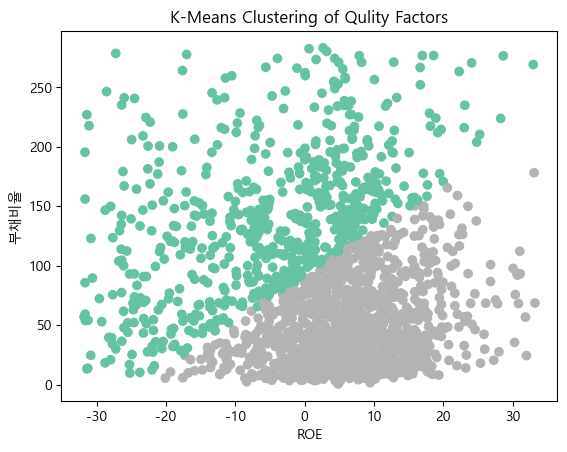

In [49]:
plt.scatter(df3_cleaned['ROE'], df3_cleaned['부채비율'], c=df3_cleaned['Cluster'], cmap='Set2' )
plt.xlabel('ROE')
plt.ylabel('부채비율')
plt.title('K-Means Clustering of Qulity Factors')
plt.show()

### 3.3 클러스터링 경계로 퀄리티 원본 데이터 분류

In [50]:
# 원본 데이터 표준화
scaled_data_original3 = scaler.transform(df3)

# 원본 데이터에 군집 분류 적용
df3['Cluster'] = df3.apply(lambda row: assign_cluster(row, kmeans_cleaned3, scaler), axis=1)

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

In [51]:
df3.Cluster.value_counts()

Cluster
1    1272
0     889
Name: count, dtype: int64

In [52]:
df3['퀄리티'] = np.where(df3['Cluster'] == 0, 'q', 'Q')

print(df3)

        ROE    부채비율  Cluster 퀄리티
0      4.26  305.26        0   q
1      3.33  319.33        0   q
2      4.64   14.85        1   Q
3     19.69  214.53        0   q
5      4.27   28.47        1   Q
...     ...     ...      ...  ..
2691   1.06   17.30        1   Q
2692  12.89   25.14        1   Q
2693   7.91  112.21        1   Q
2694  10.41  169.13        0   q
2695  16.99   36.64        1   Q

[2161 rows x 4 columns]


C:\Users\myhyu\AppData\Local\Temp\ipykernel_29460\3731119067.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['퀄리티'] = np.where(df3['Cluster'] == 0, 'q', 'Q')


In [53]:
df3[['Cluster','퀄리티']].value_counts()

Cluster  퀄리티
1        Q      1272
0        q       889
Name: count, dtype: int64

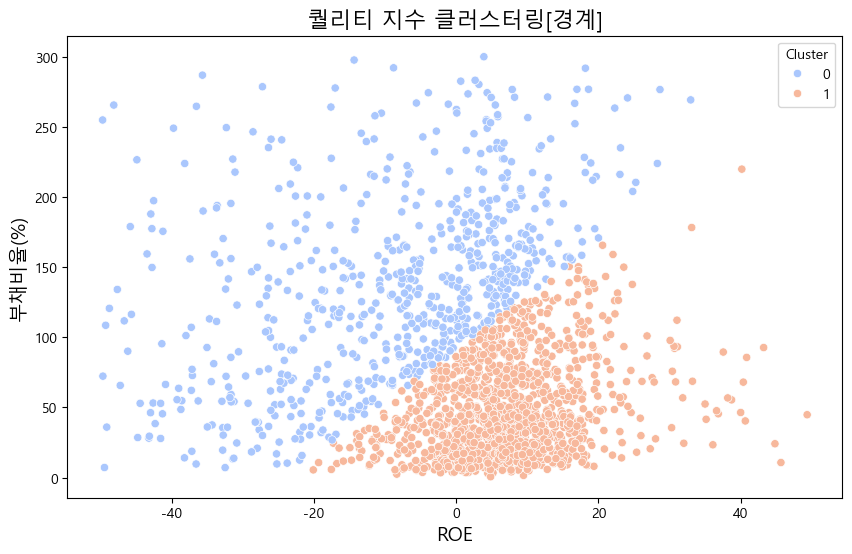

In [54]:
# 시각화
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(
    x='ROE', 
    y='부채비율', 
    hue='Cluster', 
    palette='coolwarm', 
    data=df3.query('-50<ROE<50& -5<부채비율<300')
)

# 그래프 제목과 축 레이블 설정
scatter_plot.set_title('퀄리티 지수 클러스터링[경계]', fontsize=16)
scatter_plot.set_xlabel('ROE', fontsize=14)
scatter_plot.set_ylabel('부채비율(%)', fontsize=14)

plt.show()

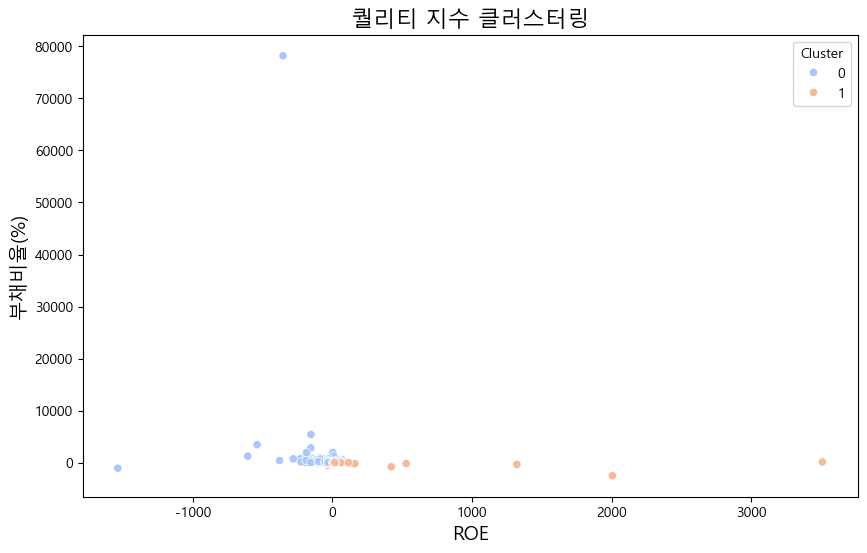

In [55]:
# 시각화
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(
    x='ROE', 
    y='부채비율', 
    hue='Cluster', 
    palette='coolwarm', 
    data=df3
)

# 그래프 제목과 축 레이블 설정
scatter_plot.set_title('퀄리티 지수 클러스터링', fontsize=16)
scatter_plot.set_xlabel('ROE', fontsize=14)
scatter_plot.set_ylabel('부채비율(%)', fontsize=14)

plt.show()

In [56]:
df3.drop(columns=['Cluster'], inplace=True)
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2161 entries, 0 to 2695
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ROE     2161 non-null   float64
 1   부채비율    2161 non-null   float64
 2   퀄리티     2161 non-null   object 
dtypes: float64(2), object(1)
memory usage: 67.5+ KB


C:\Users\myhyu\AppData\Local\Temp\ipykernel_29460\2822117819.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.drop(columns=['Cluster'], inplace=True)


---
## 4. 변동성

In [57]:
df4 = df[['베타','일별수익률표준편차']]
df4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2161 entries, 0 to 2695
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   베타         2161 non-null   float64
 1   일별수익률표준편차  2161 non-null   float64
dtypes: float64(2)
memory usage: 50.6 KB


In [58]:
df4.corr()

,베타,일별수익률표준편차
베타,1.000000,0.184995
일별수익률표준편차,0.184995,1.000000


### 4.1 변동성 데이터 극단치 제거 
df4_cleaned

In [59]:
# 극단치 제거된 데이터
df4_cleaned = remove_outliers_iqr(df4)

df4_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2023 entries, 0 to 2695
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   베타         2023 non-null   float64
 1   일별수익률표준편차  2023 non-null   float64
dtypes: float64(2)
memory usage: 47.4 KB


C:\Users\myhyu\AppData\Local\Temp\ipykernel_29460\1259426749.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df4_cleaned['베타'], kde=True, ax=axes[0])
C:\Users\myhyu\AppData\Local\Temp\ipykernel_29460\1259426749.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df4_cleaned['일별수익률표준편차'], kde

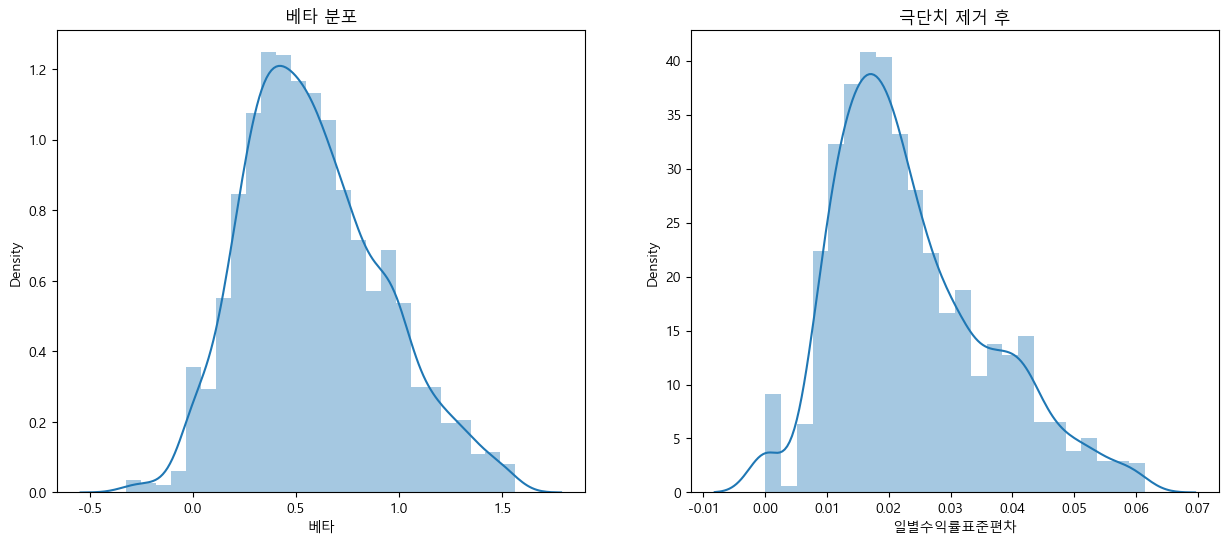

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# distplot
sns.distplot(df4_cleaned['베타'], kde=True, ax=axes[0])
axes[0].set_title('베타 분포')

# boxplot
sns.distplot(df4_cleaned['일별수익률표준편차'], kde=True, ax=axes[1])
axes[1].set_title('일별수익률표준편차 분포')

plt.title('극단치 제거 후')
plt.show()

### 4.2 변동성 지수 클러스터링

In [61]:
# 데이터 표준화
scaler = StandardScaler()
scaled_data_cleaned4 = scaler.fit_transform(df4_cleaned)

# K-Means 클러스터링 수행
kmeans_cleaned4 = KMeans(n_clusters=2, random_state=42)
df4_cleaned['Cluster'] = kmeans_cleaned4.fit_predict(scaled_data_cleaned4)

# 클러스터링 결과
df4_cleaned['Cluster'].value_counts()

C:\Users\myhyu\AppData\Local\Temp\ipykernel_29460\2493760396.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4_cleaned['Cluster'] = kmeans_cleaned4.fit_predict(scaled_data_cleaned4)


Cluster
1    1242
0     781
Name: count, dtype: int64

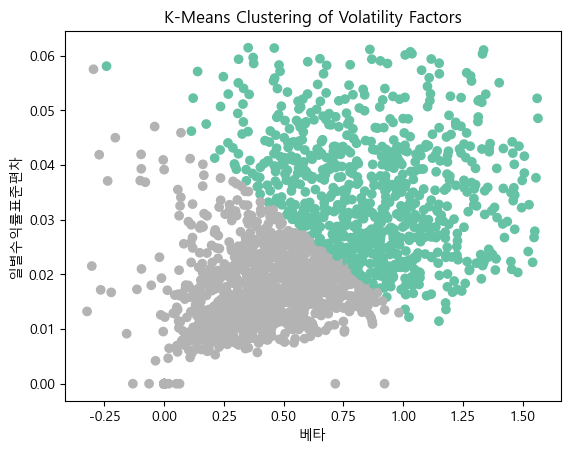

In [62]:
plt.scatter(df4_cleaned['베타'], df4_cleaned['일별수익률표준편차'], c=df4_cleaned['Cluster'], cmap='Set2' )
plt.xlabel('베타')
plt.ylabel('일별수익률표준편차')
plt.title('K-Means Clustering of Volatility Factors')
plt.show()

### 4.3 클러스터링 경계로 변동성 원본 데이터 분류

In [63]:
# 원본 데이터 표준화
scaled_data_original4 = scaler.transform(df4)

# 원본 데이터에 군집 분류 적용
df4['Cluster'] = df4.apply(lambda row: assign_cluster(row, kmeans_cleaned4, scaler), axis=1)

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\AppData\Local\Temp\ipykernel_29460\3881277070.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['Cluster'] = df4.apply(lambda row: assign_cluster(row, kmeans_cleaned4, scaler), axis=1)


In [64]:
df4.Cluster.value_counts()

Cluster
1    1247
0     914
Name: count, dtype: int64

In [65]:
df4['변동성'] = np.where(df4['Cluster'] == 0, 'v',  'V')

print(df4)

           베타  일별수익률표준편차  Cluster 변동성
0     0.52692   0.017551        1   V
1     0.46803   0.014387        1   V
2     0.65719   0.021352        1   V
3     0.29867   0.018335        1   V
5     0.47972   0.019566        1   V
...       ...        ...      ...  ..
2691 -0.24123   0.058064        0   v
2692  0.35645   0.009593        1   V
2693  0.42538   0.017679        1   V
2694  0.45468   0.016560        1   V
2695  0.52392   0.017794        1   V

[2161 rows x 4 columns]


C:\Users\myhyu\AppData\Local\Temp\ipykernel_29460\1833163528.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['변동성'] = np.where(df4['Cluster'] == 0, 'v',  'V')


In [66]:
df4[['Cluster','변동성']].value_counts()

Cluster  변동성
1        V      1247
0        v       914
Name: count, dtype: int64

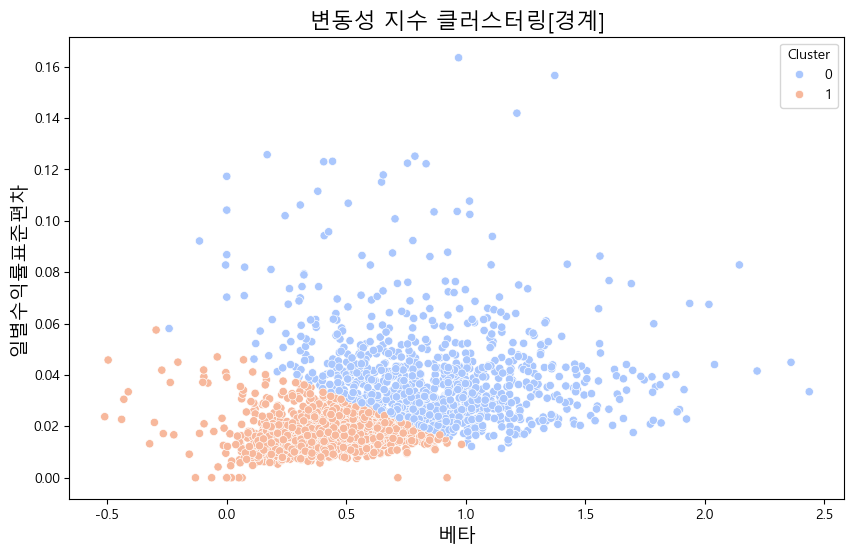

In [67]:
# 시각화
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(
    x='베타', 
    y='일별수익률표준편차', 
    hue='Cluster', 
    palette='coolwarm', 
    data=df4.query('-5<베타<5 & 일별수익률표준편차<0.2')
)

# 그래프 제목과 축 레이블 설정
scatter_plot.set_title('변동성 지수 클러스터링[경계]', fontsize=16)
scatter_plot.set_xlabel('베타', fontsize=14)
scatter_plot.set_ylabel('일별수익률표준편차', fontsize=14)

plt.show()

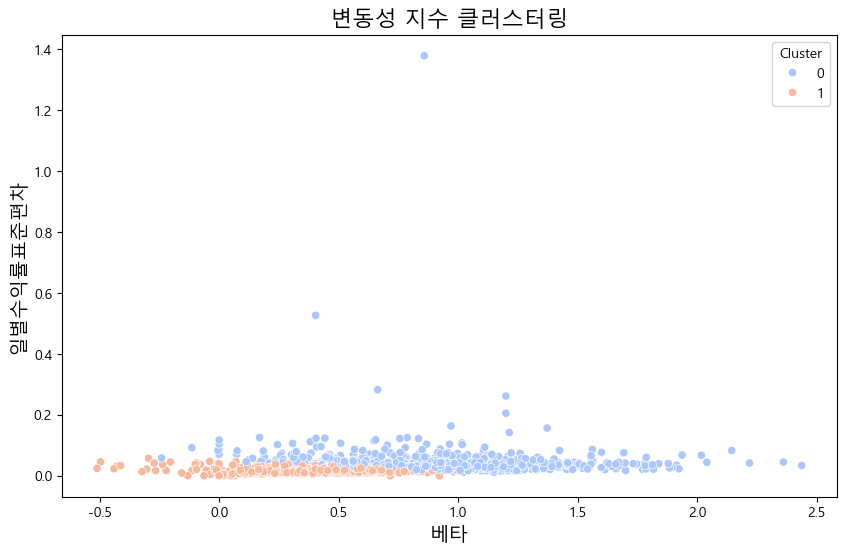

In [68]:
# 시각화
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(
    x='베타', 
    y='일별수익률표준편차', 
    hue='Cluster', 
    palette='coolwarm', 
    data=df4
)

# 그래프 제목과 축 레이블 설정
scatter_plot.set_title('변동성 지수 클러스터링', fontsize=16)
scatter_plot.set_xlabel('베타', fontsize=14)
scatter_plot.set_ylabel('일별수익률표준편차', fontsize=14)

plt.show()

In [69]:
df4.drop(columns=['Cluster'], inplace=True)
df4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2161 entries, 0 to 2695
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   베타         2161 non-null   float64
 1   일별수익률표준편차  2161 non-null   float64
 2   변동성        2161 non-null   object 
dtypes: float64(2), object(1)
memory usage: 67.5+ KB


C:\Users\myhyu\AppData\Local\Temp\ipykernel_29460\2271981119.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4.drop(columns=['Cluster'], inplace=True)


---
# 5. 데이터 합치기

In [70]:
df #원본 데이터

,기업코드,영업이익률,순이익률,매출액차,부채비율,PER,PBR,ROE,매출성장률,기업명,EV,EBITDA,EV/EBITDA,베타,일별수익률표준편차
0,095570,7.95,2.16,2448.0,305.26,13.03,0.52,4.26,-0.970874,AJ네트웍스,11528.0,615.0,18.744715,0.52692,0.017551
1,006840,8.08,3.56,11934.0,319.33,10.23,0.33,3.33,3.235294,AK홀딩스,27192.0,1606.0,16.931507,0.46803,0.014387
2,027410,9.55,9.71,1185.0,14.85,4.76,0.22,4.64,-3.970827,BGF,6049.0,185.0,32.697297,0.65719,0.021352
3,282330,1.67,1.20,19538.0,214.53,10.62,1.98,19.69,-4.234879,BGF리테일,20343.0,1597.0,12.738259,0.29867,0.018335
5,001460,13.31,10.27,387.0,28.47,18.37,0.77,4.27,-22.132797,BYC,3491.0,84.0,41.559524,0.47972,0.019566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2691,024060,-0.59,0.41,306.0,17.30,179.80,1.84,1.06,-4.968944,흥구석유,1572.0,-2.0,-786.000000,-0.24123,0.058064
2692,010240,9.20,9.77,353.0,25.14,5.56,0.62,12.89,2.023121,흥국,690.0,40.0,17.250000,0.35645,0.009593
2693,189980,8.20,3.72,225.0,112.21,12.28,0.91,7.91,15.979381,흥국에프엔비,1725.0,37.0,46.621622,0.42538,0.017679
2694,037440,3.17,5.63,563.0,169.13,13.10,1.19,10.41,-14.437690,희림,947.0,32.0,29.593750,0.45468,0.016560


In [69]:
# 데이터프레임을 수직으로 결합
df_total = pd.concat([df[['기업코드','기업명']],df1, df2, df3, df4], axis=1)
df_total['종목분류지표'] = df_total['수익성']+df_total['효율성']+df_total['퀄리티']+df_total['변동성']
df_total

,기업코드,기업명,영업이익률,순이익률,수익성,PBR,EV/EBITDA,효율성,ROE,부채비율,Cluster,퀄리티,베타,일별수익률표준편차,변동성,기업분류지표
0,095570,AJ네트웍스,7.95,2.16,p,0.52,18.744715,e,4.26,305.26,0,q,0.52692,0.017551,V,peqV
1,006840,AK홀딩스,8.08,3.56,p,0.33,16.931507,e,3.33,319.33,0,q,0.46803,0.014387,V,peqV
2,027410,BGF,9.55,9.71,p,0.22,32.697297,e,4.64,14.85,1,Q,0.65719,0.021352,V,peQV
3,282330,BGF리테일,1.67,1.20,P,1.98,12.738259,E,19.69,214.53,0,q,0.29867,0.018335,V,PEqV
5,001460,BYC,13.31,10.27,p,0.77,41.559524,e,4.27,28.47,1,Q,0.47972,0.019566,V,peQV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2691,024060,흥구석유,-0.59,0.41,P,1.84,-786.000000,e,1.06,17.30,1,Q,-0.24123,0.058064,v,PeQv
2692,010240,흥국,9.20,9.77,p,0.62,17.250000,e,12.89,25.14,1,Q,0.35645,0.009593,V,peQV
2693,189980,흥국에프엔비,8.20,3.72,p,0.91,46.621622,e,7.91,112.21,1,Q,0.42538,0.017679,V,peQV
2694,037440,희림,3.17,5.63,p,1.19,29.593750,e,10.41,169.13,0,q,0.45468,0.016560,V,peqV


In [70]:
df_final = df_total[['기업코드','기업명','수익성','효율성','퀄리티','변동성','종목분류지표']]
df_final

,기업코드,기업명,수익성,효율성,퀄리티,변동성,기업분류지표
0,095570,AJ네트웍스,p,e,q,V,peqV
1,006840,AK홀딩스,p,e,q,V,peqV
2,027410,BGF,p,e,Q,V,peQV
3,282330,BGF리테일,P,E,q,V,PEqV
5,001460,BYC,p,e,Q,V,peQV
...,...,...,...,...,...,...,...
2691,024060,흥구석유,P,e,Q,v,PeQv
2692,010240,흥국,p,e,Q,V,peQV
2693,189980,흥국에프엔비,p,e,Q,V,peQV
2694,037440,희림,p,e,q,V,peqV


In [71]:
df_final.to_csv('종목분류지표_최종.csv', encoding='cp949', index=False)

In [72]:
df_final['종목분류지표'].value_counts()

기업분류지표
peQV    460
PeqV    225
PeQV    218
PEqv    189
peQv    143
Peqv    141
pEQv    132
PeQv    115
peqV    111
PEQv     90
PEqV     85
pEQV     74
peqv     59
pEqv     45
PEQV     40
pEqV     34
Name: count, dtype: int64

In [88]:
df_groupby = df_final.groupby(by='종목분류지표')[['기업코드','기업명']].agg({'기업코드': list, '기업명': list}).reset_index()
df_groupby

,기업분류지표,기업코드,기업명
0,PEQV,"[039570, 003920, 006280, 000100, 381970, 00569...","[HDC랩스, 남양유업, 녹십자, 유한양행, 케이카, 파미셀, 효성ITX, KS인더..."
1,PEQv,"[373220, 302440, 037270, 020150, 006110, 06827...","[LG에너지솔루션, SK바이오사이언스, YG PLUS, 롯데에너지머티리얼즈, 삼아알..."
2,PEqV,"[282330, 002210, 032350, 090370, 005030, 00441...","[BGF리테일, 동성제약, 롯데관광개발, 메타랩스, 부산주공, 서울식품, 성안머티리..."
3,PEqv,"[010620, 329180, 003580, 000040, 011810, 00271...","[HD현대미포, HD현대중공업, HLB글로벌, KR모터스, STX, TCC스틸, 금..."
4,PeQV,"[001530, 001940, 181710, 034120, 001770, 00236...","[DI동일, KISCO홀딩스, NHN, SBS, SHD, SH에너지화학, SK케미칼..."
5,PeQv,"[322000, 003560, 092220, 058850, 051910, 00916...","[HD현대에너지솔루션, IHQ, KEC, KTcs, LG화학, SIMPAC, SK아..."
6,PeqV,"[079160, 000120, 375500, 017940, 001250, 00707...","[CJ CGV, CJ대한통운, DL이앤씨, E1, GS글로벌, GS리테일, HJ중공..."
7,Peqv,"[009540, 033180, 034220, 037560, 006260, 00068...","[HD한국조선해양, KH 필룩스, LG디스플레이, LG헬로비전, LS, LS네트웍스..."
8,pEQV,"[383220, 114090, 069620, 023450, 002840, 26828...","[F&F, GKL, 대웅제약, 동남합성, 미원상사, 미원에스씨, 삼성바이오로직스, ..."
9,pEQv,"[267260, 001060, 178920, 012510, 145720, 00640...","[HD현대일렉트릭, JW중외제약, PI첨단소재, 더존비즈온, 덴티움, 삼성SDI, ..."


In [89]:
df_groupby.to_csv('종목분류지표_최종_groupby.csv', encoding='cp949', index=False)